## The SASE Source Module
XFEL pulses seldom come alone - in the following section, we demonstrate how the 'phenom.source' module can be used to generate large ensembles of XFEL pulses.

To do so, we begin by importing the SASE source module

In [1]:
from phenom.source import SASE_Source

### Store a Pulse

The SASE source class provides a mechanism of generating multiple pulses and storing them to individual .h5 files. In the simplest case, it takes as its inputs identical parameters to the sase_source function defined in the previous section.

In [12]:
import numpy as np

## define the spatial/temporal mesh
x = y = np.linspace(-250e-06, 250e-06, 500) 
t = np.linspace(-25e-15, 25e-15, 250)

## define the pulse
src = SASE_Source(x = x,
                  y = y,
                  t = t,
                  photon_energy = 10e3,
                  pulse_energy = 1e-03,
                  pulse_duration = 15e-15,
                  bandwidth = 1e-12,
                  sigma = 50e-06,
                  div = 2.5e-03,
                  x0 = 0.0,
                  y0 = 0.0,
                  t0 = 0.0,
                  theta_x = 0.0,
                  theta_y = 0.0,
                  domain = 'time'
                  )

which we can within a .h5 file:

In [13]:
import os

save_loc = "./sase_field.h5"
src.generate_pulses(save_loc)

### Load a Pulse from Memory

The SASE_Source module stores pulses within a master .h5 file

In [14]:
import h5py as h5


with h5.File(save_loc, mode = 'r') as hf:
    
    print("Pulses in the master file:")
    print((hf.keys()), "\n")
    
    print("Contents of each pulse:")
    print(hf['pulse000'].keys(), "\n")
    
    print("Pulse Mesh Fields:")
    print(hf['pulse000']['mesh'].keys(), "\n")   
    
    print("Pulse Parameters:")
    print(hf['pulse000']['params'].keys(), "\n")   
    
    print("Pulse Data:")
    print("Type: ", hf['pulse000']['data'][()].dtype)   
    print("Shape: ", hf['pulse000']['data'][()].shape)   

Pulses in the master file:
<KeysViewHDF5 ['pulse000']> 

Contents of each pulse:
<KeysViewHDF5 ['data', 'mesh', 'params']> 

Pulse Mesh Fields:
<KeysViewHDF5 ['t', 'x', 'y']> 

Pulse Parameters:
<KeysViewHDF5 ['bandwidth', 'div', 'file', 'photon_energy', 'pulse_duration', 'pulse_energy', 'sigma', 't0', 'theta_x', 'theta_y', 'x0', 'y0']> 

Pulse Data:
Type:  complex128
Shape:  (500, 500, 250)


To complete this example, lets load the electric field and mesh of the first pulse, and plot its intensity as demonstrated eariler

In [15]:
with h5.File(save_loc, mode = 'r') as hf:
    
    x = sase_pulse = hf['pulse000']['mesh']['x'][()]
    y = sase_pulse = hf['pulse000']['mesh']['y'][()]
    t = sase_pulse = hf['pulse000']['mesh']['t'][()]
    
    sase_pulse = hf['pulse000']['data'][()]

Text(0.5, 0, 'Time (fs)')

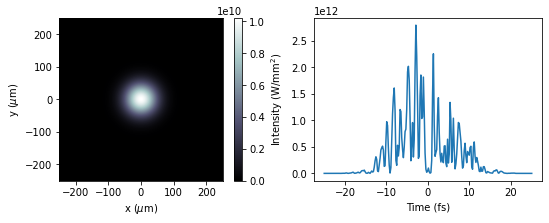

In [16]:
from matplotlib import pyplot as plt
 
fig, [ax1, ax2] = plt.subplots(1,2, figsize = (9,3))

### spatial intensity
im = ax1.imshow((abs(sase_pulse)**2).sum(axis = 2),
                extent = [x.min() * 1e06,
                          x.max() * 1e06,
                          y.min() * 1e06,
                          y.max() * 1e06],
                cmap = 'bone'
                )

plt.colorbar(im, label = "Intensity (W/mm$^2$)", ax = ax1)

ax1.set_xlabel('x ($\mu$m)')
ax1.set_ylabel('y ($\mu$m)')


ax2.plot(t*1e15, (abs(sase_pulse)**2).sum(axis = (0,1)))
ax2.set_xlabel("Time (fs)")

## Generating Multiple Pulses
The advantadge that the SASE pulse class brings over the sase_pulse function is the capacity to generate ensembles of pulses in a pythonised manner. Each of the non-mesh variables of the SASE pulse class can take the form of a list, numpy.ndarray or python 'lambda'.

The source module will generate and save N pulses to the SASE master .h5, where N is the length of the longest non-integer input of the function.

Let's consider a few examples

### Pulses from Lists
Suppose we want to consider a set of 5 pulses in the energy range 1-5 keV.
If these pulses have identical properties, other than photon energy, we can generate them as follows:

In [7]:
energies = [1000,2000,3000,4000,5000] ### list of energies in eV

## using the properties defined above
src = SASE_Source(x = x,
                  y = y,
                  t = t,
                  photon_energy = energies,
                  pulse_energy = 1e-04,
                  pulse_duration = 15e-15,
                  bandwidth = 1e-12,
                  sigma = 50e-06,
                  div = 2.5e-03,
                  x0 = 0.0,
                  y0 = 0.0,
                  t0 = 0.0,
                  theta_x = 0.0,
                  theta_y = 0.0
                  )

## storing these avefronts in the following location
save_loc = "./sase_field.h5"
src.generate_pulses(save_loc)

The .h5 master now contains 5 SASE pulses. We can check their paramters

In [8]:
import h5py as h5


with h5.File(save_loc, mode = 'r') as hf:
    
    print("Pulses in the master file:")
    print((hf.keys()), "\n")
    
    for key in hf.keys():
        
        print("Pulse Parameters:")
        print(hf[key]['params']['photon_energy'][()],"eV", "\n")   


Pulses in the master file:
<KeysViewHDF5 ['pulse000', 'pulse001', 'pulse002', 'pulse003', 'pulse004']> 

Pulse Parameters:
1000 eV 

Pulse Parameters:
2000 eV 

Pulse Parameters:
3000 eV 

Pulse Parameters:
4000 eV 

Pulse Parameters:
5000 eV 



We can compare their spectrums:

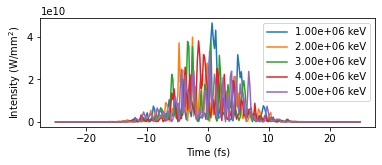

In [9]:
fig, ax = plt.subplots(figsize = (6,2))

with h5.File(save_loc, mode = 'r') as hf:
    
    for key in hf.keys():
        sase_pulse = hf[key]['data'][()]
        t = hf[key]['mesh']['t'][()]
        photon_energy = hf[key]['params']['photon_energy'][()]
        
        ax.plot(t*1e15, (abs(sase_pulse)**2).sum(axis = (0,1)),
               label = '{:.2e} keV'.format(photon_energy*1e3))
        
    ax.legend()
    
    ax.set_ylabel("Intensity (W/mm$^2$)")
    ax.set_xlabel("Time (fs)")

### Pulses from Arrays
Let's now consider the case of a pulse with a fluctuating center-of-mass in the transverse-plane. If this process is determininstic, we can define a set of input parameters from an arbitrary function.

In [10]:
x0 = np.linspace(-100e-06,100e-06,5)
y0 = np.linspace(-100e-06,100e-06,5)

Using these values as the input to the SASE_Source function yields:

In [11]:
## using the properties defined above
src = SASE_Source(x = x,
                  y = y,
                  t = t,
                  photon_energy = 10e03,
                  pulse_energy = 1e-04,
                  pulse_duration = 15e-15,
                  bandwidth = 1e-12,
                  sigma = 50e-06,
                  div = 2.5e-03,
                  x0 = x0, ### provide coordinates here
                  y0 = y0, ### and here
                  t0 = 0.0,
                  theta_x = 0.0,
                  theta_y = 0.0
                  )

## storing these avefronts in the following location
save_loc = "./sase_field.h5"
src.generate_pulses(save_loc)

which we can check from the stored pulse intensites:

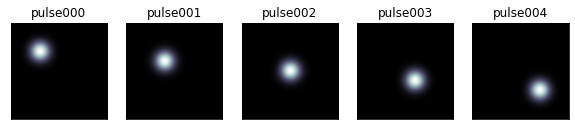

In [12]:
fig, ax = plt.subplots(1,5, figsize = (10,2))
ax = ax.flatten()

with h5.File(save_loc, mode = 'r') as hf:
    
    for itr, key in enumerate(hf.keys()):
        
        ax[itr].set_xticks([])
        ax[itr].set_yticks([])
        
        sase_pulse = hf[key]['data'][()]
        ax[itr].imshow((abs(sase_pulse)**2).sum(axis = 2),
                        cmap = 'bone'
                    )
        
        ax[itr].set_title(key)

Note that we can combine this method with the previous changes in photon energy if the length of the inputs are equivalent

In [13]:
energies = [1000,2000,3000,4000,5000] ### list of energies in eV

## using the properties defined above
src = SASE_Source(x = x,
                  y = y,
                  t = t,
                  photon_energy = energies,
                  pulse_energy = 1e-04,
                  pulse_duration = 15e-15,
                  bandwidth = 1e-12,
                  sigma = 50e-06,
                  div = 2.5e-03,
                  x0 = x0, ### provide coordinates here
                  y0 = y0, ### and here
                  t0 = 0.0,
                  theta_x = 0.0,
                  theta_y = 0.0
                  )

## storing these avefronts in the following location
save_loc = "./sase_field.h5"
src.generate_pulses(save_loc)

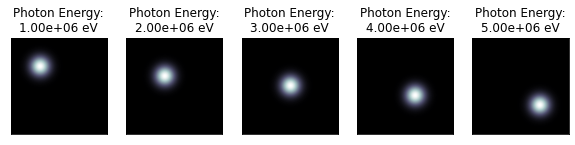

In [14]:
fig, ax = plt.subplots(1,5, figsize = (10,2))
ax = ax.flatten()

with h5.File(save_loc, mode = 'r') as hf:
    
    for itr, key in enumerate(hf.keys()):
        
        ax[itr].set_xticks([])
        ax[itr].set_yticks([])
        
        sase_pulse = hf[key]['data'][()]
        ax[itr].imshow((abs(sase_pulse)**2).sum(axis = 2),
                        cmap = 'bone'
                    )
        photon_energy = hf[key]['params']['photon_energy'][()]
        ax[itr].set_title("Photon Energy:\n{:.2e} eV".format(photon_energy*1e3))

### Pulses from Lambdas
The SASE pulse model is inherently stochastic due to the partially random SASE spectral distribution. Using python lambdas, we can create a source that with properties that fluctuate in time.

In [15]:
energies = [1000,2000,3000,4000,5000] ### list of energies in eV

## using the properties defined above
src = SASE_Source(x = x,
                  y = y,
                  t = t,
                  photon_energy = energies,
                  pulse_energy = 1e-04,
                  pulse_duration = 15e-15,
                  bandwidth = 1e-12,
                  sigma = lambda: np.random.rand()*250e-06,
                  div = 2.5e-03,
                  x0 = x0, ### provide coordinates here
                  y0 = y0, ### and here
                  t0 = 0.0,
                  theta_x = 0.0,
                  theta_y = 0.0
                  )

## storing these avefronts in the following location
save_loc = "./sase_field.h5"
src.generate_pulses(save_loc)

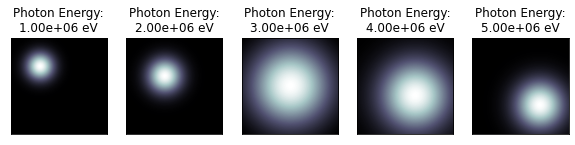

In [16]:
fig, ax = plt.subplots(1,5, figsize = (10,2))
ax = ax.flatten()

with h5.File(save_loc, mode = 'r') as hf:
    
    for itr, key in enumerate(hf.keys()):
        
        ax[itr].set_xticks([])
        ax[itr].set_yticks([])
        
        sase_pulse = hf[key]['data'][()]
        ax[itr].imshow((abs(sase_pulse)**2).sum(axis = 2),
                        cmap = 'bone'
                    )
        photon_energy = hf[key]['params']['photon_energy'][()]
        ax[itr].set_title("Photon Energy:\n{:.2e} eV".format(photon_energy*1e3))

In the following example - we demonstrate how these properties can be used to make a custom represenation of your SASE source